# Inference: Adaptive Covariance Rao-Blackwell MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mc.html) detailed in Algorithm 3 of [1].

[1] A tutorial on adaptive MCMC
    Christophe Andrieu and Johannes Thoms, Statistical Computing,
    2008, 18: 343-373
    [https://doi.org/10.1007/s11222-008-9110-y](https://doi.org/10.1007/s11222-008-9110-y)

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function that assumes noise has been integrated out (assuming a uniform prior on noise param)
log_likelihood = pints.GaussianIntegratedUniformLogLikelihood(problem, lower=noise * 0.1, upper=noise * 100)

# Create a uniform prior over both the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.RaoBlackwellACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 10 iterations -- only short period needed for this model
mcmc.set_initial_phase_iterations(10)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


The chains are very quick to converge here, even with a short initial period.

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.00    563.18  207.79
k        500.54  0.49    499.58  500.22  500.53  500.86  501.51   1.00    643.64  237.48


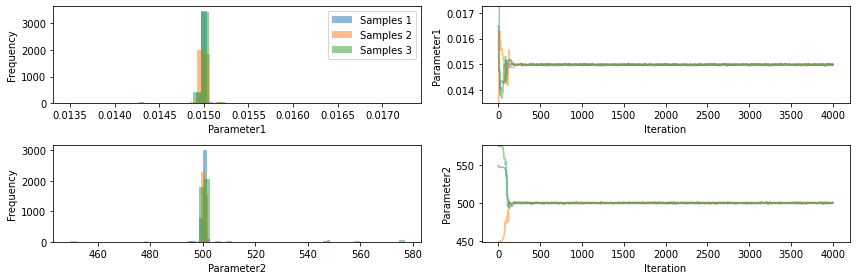

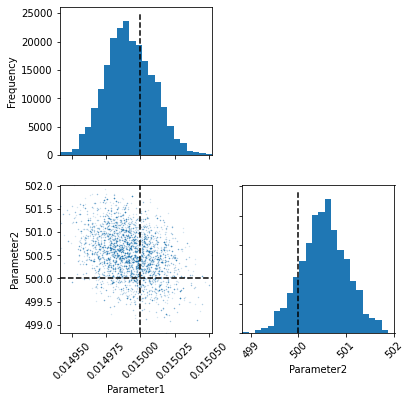

In [2]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['r', 'k'])
print(results)

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=real_parameters,)

# Show graphs
plt.show()